In [ ]:
#!pip install petals seaborn

In [66]:
import torch
torch.manual_seed(1337)

import random
random.seed(1337)

import numpy as np
np.random.seed(1337)

In [ ]:
from transformers import BloomTokenizerFast 
from petals import DistributedBloomForCausalLM
from collections import defaultdict
from tqdm import tqdm

MODEL_NAME = "bigscience/bloom-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

In [5]:
import json
def read_jsonl(path: str):
    with open(path) as fh:
        return [json.loads(line) for line in fh.readlines() if line]

In [190]:
train = read_jsonl("./train.jsonl")
random.shuffle(train)
test = read_jsonl("./test.jsonl")
random.shuffle(test)

In [9]:
test[0]

{'question': 'Katherine has 5 hanging baskets to fill.  In each basket she wants to add 3 petunias and 2 sweet potato vines.  The petunias cost $3.00 apiece and the sweet potato vines cost $2.50 apiece.  How much will she spend filling all 5 hanging baskets?',
 'answer': "The petunia are $3.00 each and she wants 3 per basket so that's 3.00*3 = $<<3*3=9.00>>9.00\nThe sweet potato vines are $2.50 each and she wants 2 per basket so that's 2.5*2 = $<<2.5*2=5.00>>5.00\nFor 1 basket, the petunias will cost $9.00 and the sweet potato vines will cost $5.00 for a total of 9+5 = $<<9+5=14.00>>14.00\nEach basket will cost $14.00 to fill and she needs to fill 5 baskets for a total of 14*5 = $<<14*5=70.00>>70.00\n#### 70"}

In [ ]:
def get_prompt(n):
    prompt = ""
    for el in train[:n]:
        prompt+=f"Q: {el['question']}\n"
        prompt+=f"A: {el['answer']}\n"
    return prompt

In [ ]:
def get_ans(prompt, question, gen_arg):
    new_input = prompt
    new_input+="Q: "+question+"\n"
    new_input+="A: "
    new_input = tokenizer(new_input, return_tensors="pt")["input_ids"].cuda()
    outputs = model.generate(new_input, max_new_tokens=200, **gen_arg)
    text = tokenizer.decode(outputs[0])
    start_of_q = text.find(question)
    if start_of_q==-1:
      return None
    # print(text[start_of_q:])
    final_ans_start_idx = text.find("####",start_of_q)
    if final_ans_start_idx==-1:
      return None
    try:
      nlp_ans = int(text[final_ans_start_idx+5:text.find("\n",final_ans_start_idx)])
      return nlp_ans
    except:
      return None

In [18]:
from statistics import mean,median
import numpy as np
def get_metrics(stats):
    metrics = []
    for n_prompt in stats:
        nones= 0
        right_ans = 0
        test_cases = len(stats[n_prompt])
        l1_err = []
        relative_err = []
        for ground_truth, ans in stats[n_prompt]:
            if ans is None:
                nones+=1
                continue
            if ground_truth==ans:
                right_ans+=1
            l1_err.append(abs(ground_truth-ans))
            relative_err.append(100*(ans-ground_truth)/ground_truth)
        print(f"n_prompt = {n_prompt} mean l1_err = {mean(l1_err)}")
        print(f"n_prompt = {n_prompt} mean relative_err = {mean(relative_err)}")
        metrics.append([n_prompt,nones/test_cases,right_ans/test_cases,l1_err,relative_err])
    return metrics

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def plot_metrics(stats):
    columns = ["n_prompt", "nones_relative","acc","l1_err","relative_err"]
    df = pd.DataFrame(stats, columns=columns)
    for i in range(1,5):
        plt.figure()
        if i<=2:
            pass
            sns.barplot(x=columns[0],y=columns[i],data=df)
        else:
            fig, axs = plt.subplots(1,2,figsize=(15,5))
            df1 = df[['n_prompt',columns[i]]].explode(columns[i])
            sns.boxplot(x=columns[0], y=columns[i],data=df1,showfliers=False,ax=axs[0])
            loc = MaxNLocator(20)
            axs[0].yaxis.set_major_locator(loc)
            # g.yaxis.set_ticks(np.arange(start, end, 0.712123))
            sns.boxplot(x=columns[0], y=columns[i],data=df1,ax=axs[1])

Experiment 1: Bloom 176B, greedy

In [ ]:
prompt_experiments_greedy = defaultdict(list)
for n in tqdm([2,4,8]):
  prompt = get_prompt(n)
  for el in tqdm(test[:16]):
    ans = el["answer"]
    ground_truth = int(ans[ans.rfind("#")+1:])
    model_ans = get_ans(prompt,el["question"],{})
    prompt_experiments_greedy[n].append((ground_truth, model_ans))

In [11]:
# Полученные данные
# prompt_experiments_greedy = defaultdict(list)
# prompt_experiments_greedy[2]=[(70, 30), (342, 90), (21, 11), (14, 25), (4, 18), (220, 33600), (3, 5), (118000, None), (23, 10), (45, None), (60, 40), (5, 0), (225, None), (78, 87), (41, 500), (240, 960)]
# prompt_experiments_greedy[4]=[(70, None), (342, 116400), (21, None), (14, 30), (4, 7), (220, 400), (3, 2), (118000, None), (23, None), (45, None), (60, None), (5, 3), (225, 290), (78, 78), (41, 24), (240,120)]
# prompt_experiments_greedy[8]=[(70, None), (342, 789), (21, 9), (14, 5), (4, 35), (220, 400), (3, 9), (118000, None),(23, 7), (45, None), (60, 100), (5, 3), (225, 200), (78, 78), (41, 15), (240, 240)]

n_prompt = 2 mean l1_err = 2687.3076923076924
n_prompt = 2 mean relative_err = 1286.978064374907
n_prompt = 4 mean l1_err = 11646.2
n_prompt = 4 mean relative_err = 3407.028375632355
n_prompt = 8 mean l1_err = 61.07692307692308
n_prompt = 8 mean relative_err = 72.97438990719115


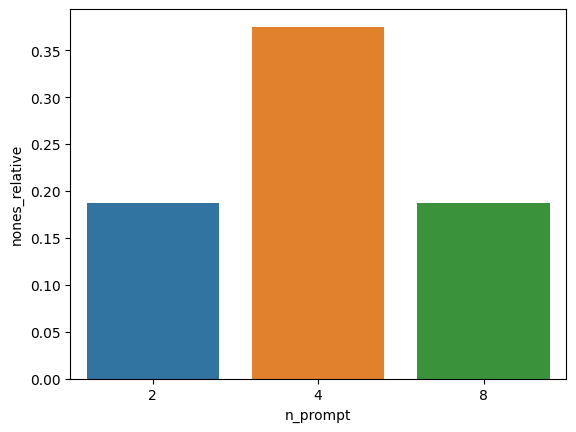

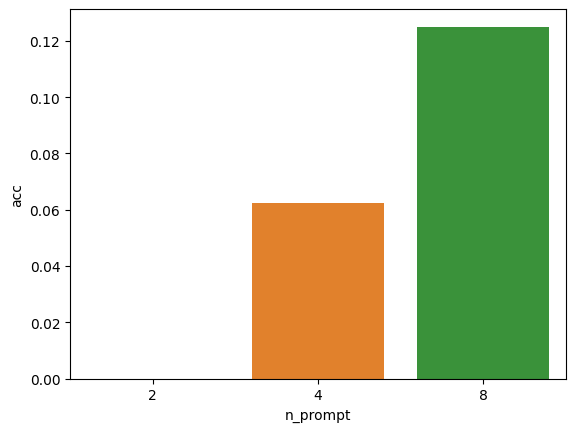

<Figure size 640x480 with 0 Axes>

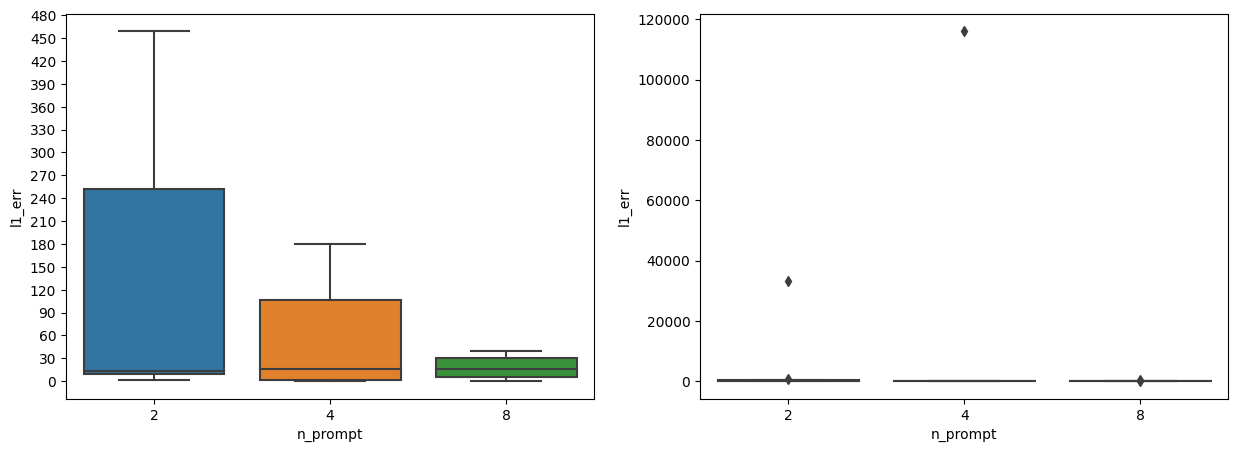

<Figure size 640x480 with 0 Axes>

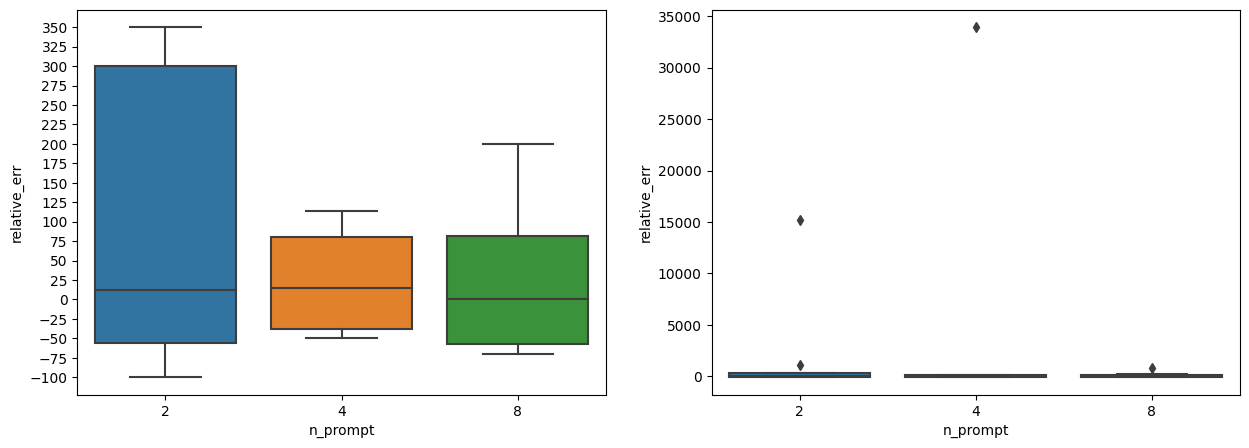

In [51]:
plot_metrics(get_metrics(prompt_experiments_greedy))

Experiment 2: Bloom 7B, greedy vs self consistency

Experiment 2.1: Bloom 7B + greedy

In [ ]:
torch.manual_seed(1337)
random.seed(1337)
np.random.seed(1337)# Из-за ограничений Google Colab, пришлось делать эксперименты в разных сессиях, восстанавливаем сиды

MODEL_NAME = "bigscience/bloom-7b1-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

train = read_jsonl("./train.jsonl")
random.shuffle(train)
test = read_jsonl("./test.jsonl")
random.shuffle(test)

In [ ]:
bloom_7b_greedy = {}
for n in [8]:
  prompt = get_prompt(n)
  bloom_7b_greedy[n]= [ [] for _ in range(16)]
  for _ in tqdm(range(1)):
    for i in tqdm(range(16)):
        el=test[i]
        ans = el["answer"]
        ground_truth = int(ans[ans.rfind("#")+1:])
        model_ans = get_ans(prompt,el["question"],{})
        bloom_7b_greedy[n][i].append((ground_truth, model_ans))

In [52]:
# Полученные данные
# bloom_7b_greedy = {}
# bloom_7b_greedy = {8: [(70, None), (342, 121), (21, None), (14, 12), (4, 80), (220, None), (3, 9), (118000, 200000), (23, 3), (45, 160), (60, 30), (5, 4), (225, None), (78, 69), (41, 10), (240, 30)]}

n_prompt = 8 mean l1_err = 6893.416666666667
n_prompt = 8 mean relative_err = 167.87806202312345


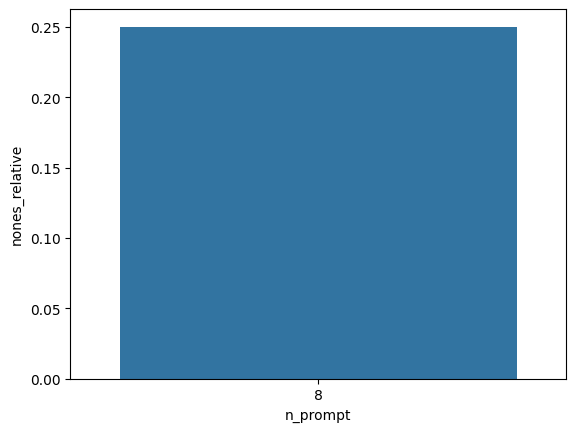

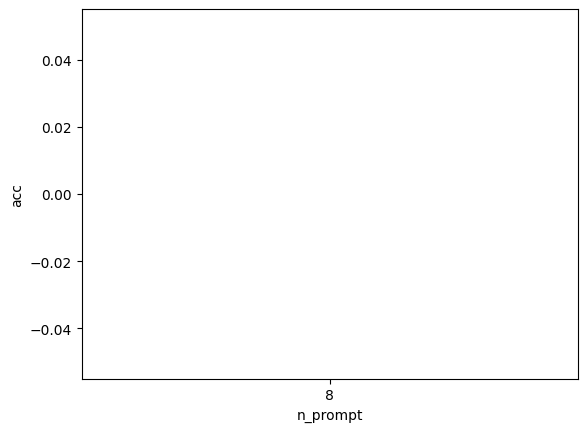

<Figure size 640x480 with 0 Axes>

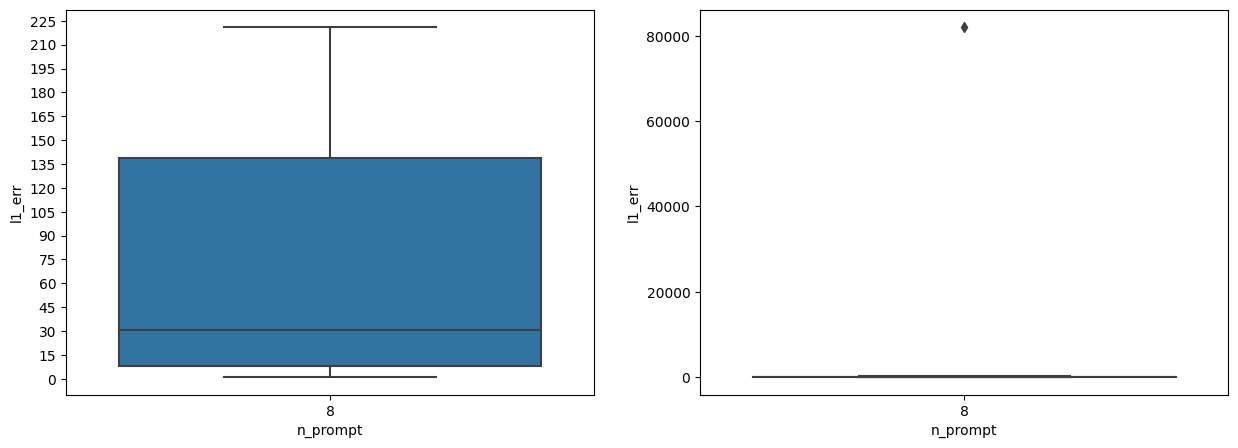

<Figure size 640x480 with 0 Axes>

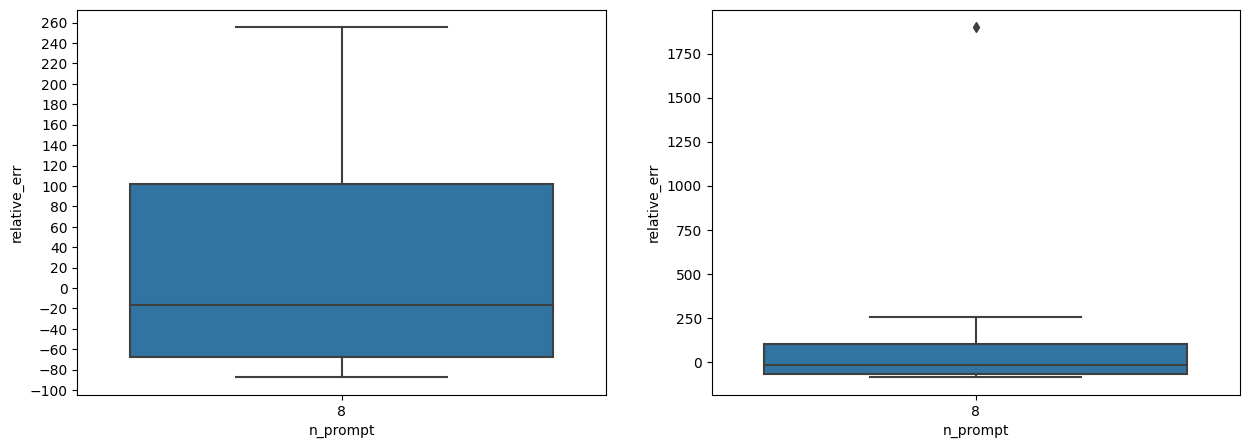

In [53]:
plot_metrics(get_metrics(bloom_7b_greedy))

Experiment 2.2: Bloom 7B + self_consistency

In [ ]:
torch.manual_seed(1337)
random.seed(1337)
np.random.seed(1337)# Из-за ограничений Google Colab, пришлось делать эксперименты в разных сессиях, восстанавливаем сиды

MODEL_NAME = "bigscience/bloom-7b1-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

train = read_jsonl("./train.jsonl")
random.shuffle(train)
test = read_jsonl("./test.jsonl")
random.shuffle(test)

In [56]:
from collections import Counter
def convert_sampling_results(results,include_nones):
    new_res = defaultdict(list)
    for n_prompt in results:
        for i in range(len(results[n_prompt])):
            ground_truth = results[n_prompt][i][0][0]
            c = Counter([x[1] for x in results[n_prompt][i] if include_nones or x[1] is not None])
            consistent = c.most_common()[0][0]
            new_res[n_prompt].append((ground_truth,consistent))
    return new_res

In [ ]:
bloom_7b_self_consistency = {}

for n in [8]:
  prompt = get_prompt(n)
  bloom_7b_self_consistency[n]= [ [] for _ in range(16)]    
  for _ in tqdm(range(40)): # 40 семплов
    for i in tqdm(range(16)): # для каждого из 16 примеров
        el=test[i]
        ans = el["answer"]
        ground_truth = int(ans[ans.rfind("#")+1:])
        model_ans = get_ans(prompt,el["question"],{"top_k":20, "temperature":0.75,"do_sample":True})
        bloom_7b_self_consistency[n][i].append((ground_truth, model_ans))


In [55]:
# Полученные данные
# bloom_7b_self_consistency = {}
# bloom_7b_self_consistency = {8: [[(70, 150), (70, 10), (70, 15), (70, 5), (70, 75), (70, 14), (70, 24), (70, None), (70, None), (70, 35), (70, 18), (70, None), (70, 75), (70, 50), (70, 15), (70, 7), (70, None), (70, 1), (70, None), (70, 10), (70, None), (70, 15), (70, 25), (70, None), (70, 25), (70, None), (70, 10), (70, None), (70, 10), (70, None), (70, None), (70, 27), (70, 27), (70, 3), (70, 21), (70, 12), (70, 20), (70, None), (70, 10), (70, 24)], [(342, None), (342, 2712), (342, None), (342, 666), (342, None), (342, 171), (342, None), (342, None), (342, 180), (342, None), (342, 77), (342, 33), (342, None), (342, 43), (342, 960), (342, 156), (342, 6), (342, None), (342, 22), (342, None), (342, 67), (342, None), (342, None), (342, 153), (342, 66), (342, None), (342, 7875), (342, None), (342, 300), (342, 18), (342, 24), (342, None), (342, None), (342, None), (342, 168), (342, 11111), (342, None), (342, 1344), (342, 75), (342, 11)], [(21, 15), (21, 240), (21, 21), (21, None), (21, 109), (21, None), (21, 22), (21, 1), (21, 1), (21, 0), (21, 38), (21, 11), (21, 7), (21, 14), (21, 22), (21, 6), (21, 16), (21, 19), (21, 8), (21, 45), (21, 13), (21, 21), (21, 22), (21, 13), (21, 2), (21, 10), (21, 23), (21, 18), (21, 11), (21, 36), (21, 21), (21, 23), (21, 19), (21, 53), (21, 5), (21, 68), (21, 14), (21, 2), (21, 23), (21, 14)], [(14, None), (14, 8), (14, 8), (14, 4), (14, 16), (14, 6), (14, 0), (14, 8), (14, 16), (14, None), (14, None), (14, 9), (14, 10), (14, 2), (14, None), (14, 8), (14, 5), (14, 24), (14, 8), (14, 13), (14, 10), (14, 25), (14, 11), (14, 2), (14, 16), (14, 11), (14, 10), (14, 4), (14, 15), (14, 2), (14, None), (14, 5), (14, 12), (14, 3), (14, 1), (14, 8), (14, 1), (14, 8), (14, 5), (14, 24)], [(4, 0), (4, 44), (4, 11), (4, 21), (4, 72), (4, 10), (4, None), (4, 10), (4, 38), (4, 5), (4, 15), (4, 84), (4, 8), (4, 36), (4, 49), (4, 42), (4, None), (4, 15), (4, 2), (4, 1), (4, 81), (4, 13), (4, 8), (4, 4), (4, 27), (4, 4), (4, 30), (4, 14), (4, 14), (4, 11), (4, 19), (4, 25), (4, 112), (4, 8), (4, None), (4, 25), (4, 48), (4, 8), (4, 14), (4, 7)], [(220, 230000), (220, 165), (220, None), (220, 2350), (220, 25), (220, 2350), (220, 1857), (220, None), (220, 2525), (220, 2465), (220, None), (220, 1650), (220, 17), (220, 1655), (220, 1830), (220, 2160), (220, 1650), (220, 750), (220, 2000), (220, 1800), (220, 1240), (220, 1265), (220, 165), (220, 336), (220, 1600), (220, None), (220, 1810), (220, 1375), (220, 1800), (220, 225), (220, 11), (220, 175), (220, None), (220, 13), (220, 8875), (220, 49600), (220, 1740), (220, None), (220, 1280), (220, 2875)], [(3, 2547), (3, 1), (3, None), (3, 5), (3, None), (3, 21), (3, 1), (3, 8), (3, 4), (3, 8), (3, 4), (3, None), (3, 10), (3, 3), (3, None), (3, 1), (3, 6), (3, None), (3, None), (3, 1), (3, 11), (3, 10), (3, 7), (3, None), (3, 5), (3, 2), (3, 3), (3, None), (3, None), (3, 2), (3, 5), (3, 3), (3, None), (3, 5), (3, None), (3, 5), (3, 4), (3, None), (3, 10), (3, 1)], [(118000, None), (118000, None), (118000, None), (118000, 10000), (118000, 0), (118000, None), (118000, None), (118000, 350), (118000, 200), (118000, 200), (118000, 150), (118000, 250), (118000, 100), (118000, 150), (118000, 24000), (118000, 250), (118000, 300), (118000, 25000), (118000, 300), (118000, None), (118000, 325000), (118000, 250), (118000, 250), (118000, None), (118000, None), (118000, 25000), (118000, 250000), (118000, None), (118000, 150), (118000, 25000), (118000, 150), (118000, 42200), (118000, 400), (118000, 200), (118000, 250), (118000, 250000), (118000, 200000), (118000, None), (118000, 18000), (118000, None)], [(23, 6), (23, 13), (23, 24), (23, 15), (23, 14), (23, 8), (23, 14), (23, 8), (23, 6), (23, 4), (23, 11), (23, 123), (23, 9), (23, 2), (23, 4), (23, 21), (23, 21), (23, 6), (23, 4), (23, 23), (23, None), (23, 12), (23, 8), (23, 4), (23, 4), (23, 2), (23, None), (23, 19), (23, 5), (23, 13), (23, 26), (23, None), (23, 8), (23, 6), (23, 18), (23, 4), (23, 9), (23, 11), (23, 6), (23, 33)], [(45, None), (45, None), (45, None), (45, 0), (45, 112), (45, None), (45, 120), (45, None), (45, 130), (45, None), (45, 120), (45, 30), (45, 7), (45, 4), (45, 1), (45, 1), (45, 240), (45, 2), (45, 60), (45, None), (45, 35), (45, 240), (45, 480), (45, 1), (45, 144), (45, 1), (45, 120), (45, None), (45, 1), (45, None), (45, 40), (45, None), (45, 78), (45, 50), (45, 240), (45, 150), (45, 240), (45, 440), (45, 120), (45, 80)], [(60, 30), (60, 120), (60, None), (60, 20), (60, 50), (60, 40), (60, 60), (60, 30), (60, 240), (60, None), (60, 120), (60, 80), (60, 15), (60, 20), (60, 40), (60, 5), (60, 40), (60, 30), (60, 20), (60, 30), (60, 200), (60, 70), (60, 20), (60, 160), (60, 15), (60, 40), (60, 120), (60, 120), (60, 0), (60, 0), (60, 5), (60, None), (60, 50), (60, 10), (60, 30), (60, 0), (60, 240), (60, 8), (60, 40), (60, 30)], [(5, 3), (5, 1), (5, None), (5, 25), (5, 2), (5, None), (5, 3), (5, 15), (5, 3), (5, 3), (5, 1), (5, 2), (5, None), (5, 1), (5, 4), (5, 3), (5, 6), (5, None), (5, 4), (5, 2), (5, None), (5, 1), (5, None), (5, 3), (5, 0), (5, 2), (5, 1), (5, 3), (5, 0), (5, 2), (5, 4), (5, None), (5, 3), (5, None), (5, 3), (5, 1), (5, 6), (5, 2), (5, None), (5, 2)], [(225, 10), (225, 180), (225, 200), (225, None), (225, 75), (225, 20), (225, 2500), (225, 50), (225, 40), (225, 20), (225, None), (225, 200), (225, 250), (225, 30), (225, 15), (225, 200), (225, 10), (225, 5), (225, 40), (225, None), (225, 250), (225, 150), (225, 16), (225, 1250), (225, None), (225, 15), (225, 25), (225, 4), (225, 20), (225, 10), (225, 175), (225, 125), (225, 80), (225, 150), (225, 265), (225, 40), (225, 1), (225, 15), (225, 8), (225, None)], [(78, None), (78, 22), (78, 13), (78, 58), (78, 81), (78, 22), (78, 82), (78, 74), (78, 108), (78, 74), (78, 82), (78, None), (78, 67), (78, 6), (78, 73), (78, 27), (78, 1), (78, None), (78, 83), (78, 10), (78, 99), (78, None), (78, None), (78, 11), (78, 10), (78, 82), (78, 12), (78, None), (78, 14), (78, 72), (78, 35), (78, 7), (78, 84), (78, 82), (78, None), (78, 72), (78, 8), (78, 14), (78, 11), (78, 10)], [(41, 20), (41, 12), (41, 25), (41, 6), (41, 140), (41, 100), (41, 5), (41, 40), (41, None), (41, 100), (41, 100), (41, 10), (41, 30), (41, 6), (41, 20), (41, 24), (41, 25), (41, 5), (41, None), (41, 10), (41, 45), (41, 30), (41, 10), (41, 20), (41, 30), (41, 305), (41, 10), (41, 25), (41, 30), (41, 8), (41, 15), (41, 15), (41, 10), (41, 20), (41, 30), (41, 25), (41, 4), (41, 500), (41, 25), (41, None)], [(240, 720), (240, 11), (240, 240), (240, None), (240, 90), (240, 30), (240, 12), (240, None), (240, 60), (240, 2), (240, 30), (240, 120), (240, 60), (240, 60), (240, 125), (240, 600), (240, 1480), (240, 180), (240, 150), (240, 100), (240, 30), (240, 60), (240, 7), (240, 60), (240, 120), (240, 3600), (240, None), (240, 180), (240, 40), (240, 144), (240, 2), (240, 10), (240, 30), (240, 60), (240, 60), (240, 120), (240, 25), (240, 12), (240, 720), (240, 10)]]}

In [57]:
bloom_7b_self_consistency_res_with_nones = convert_sampling_results(bloom_7b_self_consistency,True)
bloom_7b_self_consistency_res_without_nones = convert_sampling_results(bloom_7b_self_consistency,False)

n_prompt = 8 mean l1_err = 32.125
n_prompt = 8 mean relative_err = -28.686278594152398


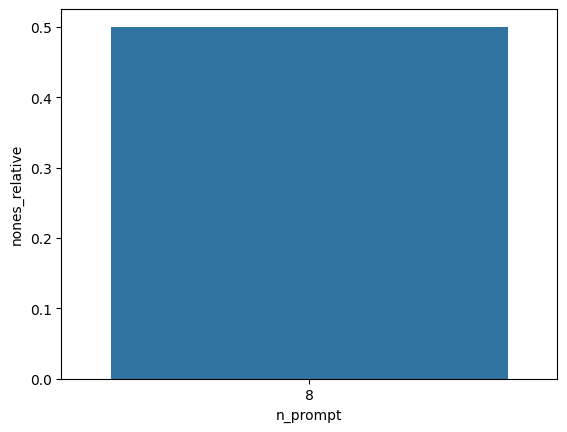

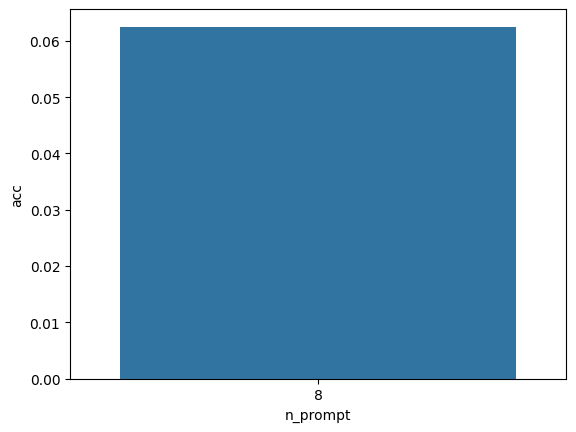

<Figure size 640x480 with 0 Axes>

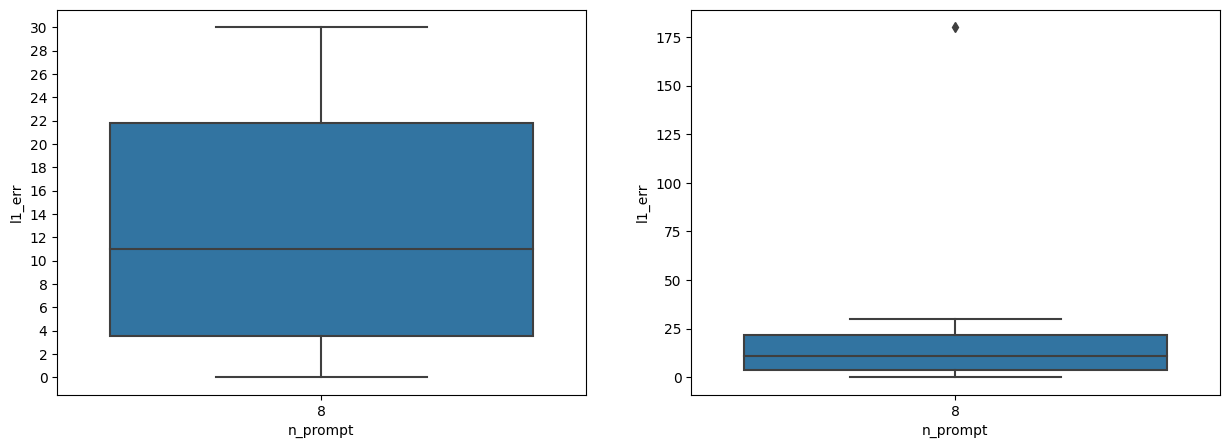

<Figure size 640x480 with 0 Axes>

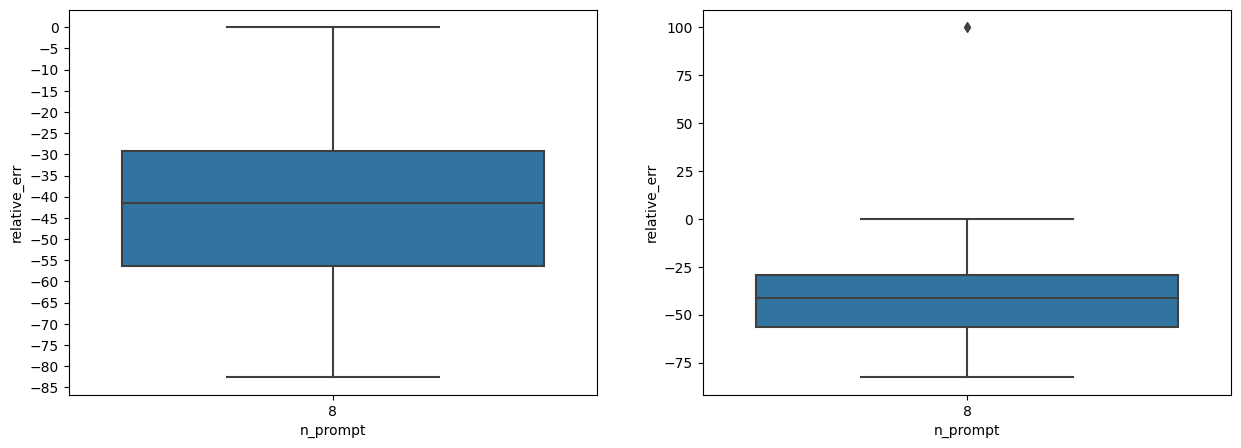

In [58]:
plot_metrics(get_metrics(bloom_7b_self_consistency_res_with_nones))

n_prompt = 8 mean l1_err = 7547.3125
n_prompt = 8 mean relative_err = -0.11762429951057535


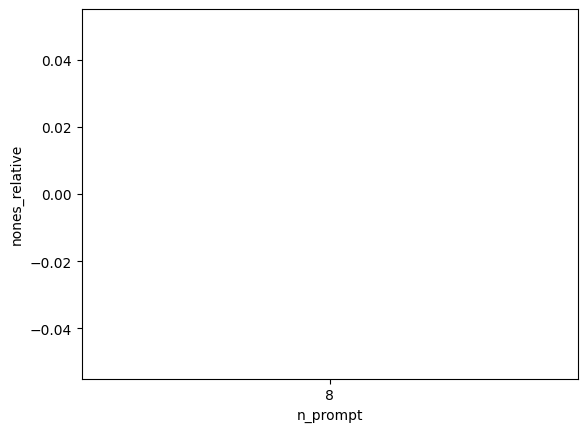

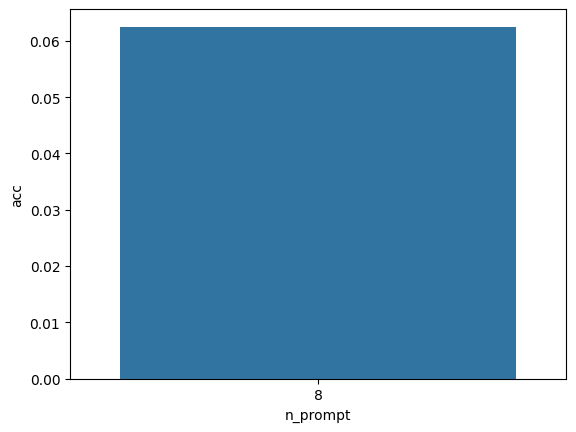

<Figure size 640x480 with 0 Axes>

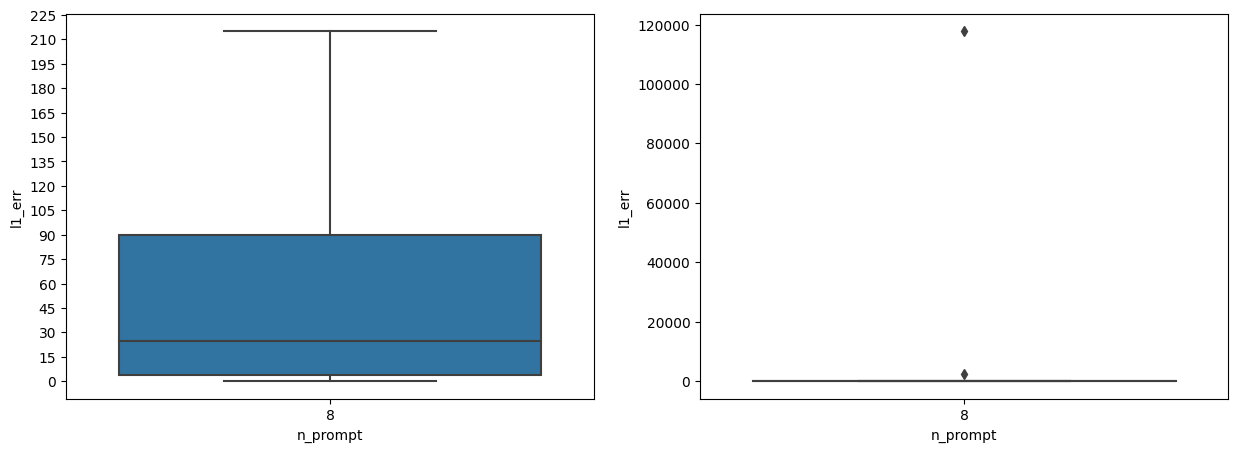

<Figure size 640x480 with 0 Axes>

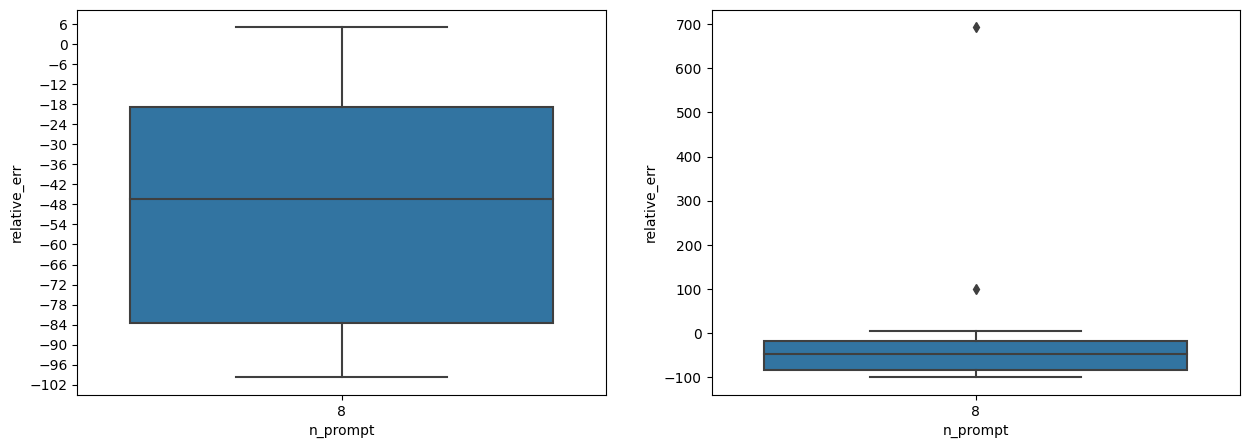

In [59]:
plot_metrics(get_metrics(bloom_7b_self_consistency_res_without_nones))

Experiment 3. self_consistency + new prompt  (Не сработало)

In [ ]:
torch.manual_seed(1337)
random.seed(1337)
np.random.seed(1337)# Из-за ограничений Google Colab, пришлось делать эксперименты в разных сессиях, восстанавливаем сиды

MODEL_NAME = "bigscience/bloom-7b1-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

train = read_jsonl("./train.jsonl")
random.shuffle(train)
test = read_jsonl("./test.jsonl")
random.shuffle(test)

In [ ]:
import math
train_digits_thoughts = {}
for idx, el in enumerate(train):
    int_ans = int(el["answer"][el["answer"].index("####")+5:].replace(",",""))
    if int_ans <= 0: continue # чтобы не было проблем с логарифмом
    num_of_thoughts = el["answer"].count("\n")
    num_of_digits = math.floor(math.log(int_ans,10)) #количество разрядов
    if not num_of_digits in train_digits_thoughts:
        train_digits_thoughts[num_of_digits] = {}
    if not num_of_thoughts in train_digits_thoughts[num_of_digits]:
        train_digits_thoughts[num_of_digits][num_of_thoughts]=[]
    train_digits_thoughts[num_of_digits][num_of_thoughts].append(idx)

In [ ]:
prompt=""
used_thoughts = set([7,8,9]) # исключаем слишком длинные цепочки
rnd  = random.Random(31337)
for num_of_digits in rnd.sample(range(0,8),8): #1 -> 8 разрядов
    available_thoughts = [x for x in list(train_digits_thoughts[num_of_digits].keys()) if x not in used_thoughts]
    if len(available_thoughts) == 0:
        used_thoughts=set([7,8,9])
        available_thoughts = [x for x in list(train_digits_thoughts[num_of_digits].keys()) if x not in used_thoughts]
    num_of_thoughts = rnd.choice(available_thoughts)
    used_thoughts.add(num_of_thoughts)
    print(num_of_thoughts, num_of_digits)
    el_idx = rnd.choice(train_digits_thoughts[num_of_digits][num_of_thoughts])
    el = train[el_idx]
    prompt+=f"Q: {el['question']}\n"
    prompt+=f"A: {el['answer']}\n"

In [ ]:
#Хар-ки нового промпта
#num_of_thoughts, num_of_digits

# 6 2
# 5 7
# 4 4
# 2 0
# 3 1
# 4 5
# 6 3
# 3 6


In [ ]:
bloom_7b_self_consistency_new_prompt = {}

for n in [8]:
  bloom_7b_self_consistency_new_prompt[n]= [ [] for _ in range(16)]
  for _ in tqdm(range(40)):
    for i in tqdm(range(16)):
        el=test[i]
        ans = el["answer"]
        ground_truth = int(ans[ans.rfind("#")+1:])
        model_ans = get_ans(prompt,el["question"],{"top_k":20, "temperature":0.75,"do_sample":True})  #
        bloom_7b_self_consistency_new_prompt[n][i].append((ground_truth, model_ans))

In [207]:
# bloom_7b_self_consistency_new_prompt = {8: [[(70, 126), (70, 22), (70, None), (70, 75000), (70, None), (70, 120), (70, None), (70, None), (70, None), (70, None), (70, None), (70, 15), (70, None), (70, 5), (70, None), (70, 54), (70, None), (70, None), (70, None), (70, 750), (70, None), (70, 300), (70, None)], [(342, None), (342, 346), (342, -4), (342, None), (342, None), (342, None), (342, None), (342, None), (342, 666), (342, 146), (342, 8200), (342, None), (342, 1725), (342, None), (342, 12), (342, 240), (342, None), (342, 1149), (342, 144), (342, None), (342, None), (342, 680), (342, 2000)], [(21, 32), (21, 12), (21, 22), (21, 14), (21, None), (21, 8), (21, 20), (21, None), (21, 11111), (21, 1), (21, 14), (21, 23), (21, None), (21, 22), (21, 77), (21, 115), (21, None), (21, None), (21, 117), (21, 24), (21, 21), (21, 62), (21, 1176)], [(14, 8), (14, 7), (14, None), (14, 720000), (14, 12), (14, 54), (14, 24), (14, None), (14, 22), (14, None), (14, 6), (14, 1), (14, 4), (14, None), (14, 8), (14, None), (14, None), (14, None), (14, 4), (14, None), (14, 12), (14, 13), (14, 9)], [(4, 10), (4, 9), (4, 47200), (4, None), (4, 144), (4, None), (4, 37), (4, None), (4, 5), (4, 16), (4, 764), (4, 16), (4, None), (4, 720), (4, 38), (4, None), (4, 90), (4, None), (4, None), (4, 10), (4, 2), (4, 50), (4, None)], [(220, 1260), (220, 125), (220, 9333), (220, None), (220, None), (220, 288), (220, 165), (220, None), (220, 80000), (220, 750), (220, 2500), (220, None), (220, None), (220, 165), (220, None), (220, None), (220, None), (220, 165), (220, 25), (220, 1310), (220, 9), (220, None), (220, 48)], [(3, 5), (3, None), (3, None), (3, 16), (3, None), (3, 10), (3, 25), (3, 0), (3, None), (3, 5), (3, None), (3, 144), (3, 8), (3, 5), (3, 6), (3, None), (3, 7), (3, None), (3, 9), (3, 8), (3, None), (3, None), (3, 5)], [(118000, 4250000), (118000, 100000), (118000, 500000), (118000, None), (118000, 4500), (118000, 250000), (118000, 200000), (118000, None), (118000, 20000), (118000, 350000), (118000, 750000), (118000, None), (118000, 400000), (118000, 90), (118000, 350), (118000, 1800), (118000, 500000), (118000, 400), (118000, 5000), (118000, None), (118000, 100000), (118000, 300000), (118000, 8000)], [(23, 4), (23, 21), (23, 8), (23, 10), (23, None), (23, 5), (23, None), (23, None), (23, 6), (23, 4), (23, 18), (23, 36), (23, None), (23, None), (23, 1), (23, 12), (23, 65), (23, 1035), (23, None), (23, 5), (23, None), (23, None), (23, None)], [(45, None), (45, None), (45, None), (45, None), (45, None), (45, None), (45, None), (45, 240), (45, None), (45, None), (45, 10440), (45, None), (45, 1600), (45, 8), (45, 720), (45, 1075), (45, 75), (45, 7200), (45, None), (45, None), (45, None), (45, 80), (45, 10)], [(60, 90), (60, 1024), (60, None), (60, 200), (60, 10), (60, 30), (60, 80), (60, 375000), (60, 15), (60, 20), (60, 5), (60, 80), (60, 10), (60, None), (60, 10), (60, 20), (60, 40), (60, -10), (60, None), (60, 10), (60, 10), (60, 10), (60, 1460)], [(5, 201), (5, 1), (5, 1), (5, 14), (5, 4), (5, None), (5, 20), (5, None), (5, 3), (5, 6), (5, 2), (5, 4), (5, None), (5, 1), (5, None), (5, 5), (5, None), (5, None), (5, 3), (5, None), (5, 2), (5, 2)], [(225, 2800), (225, 21), (225, 20), (225, 15), (225, 1050), (225, None), (225, None), (225, 60), (225, None), (225, 25), (225, 35), (225, 12), (225, None), (225, 2400000), (225, 200), (225, 30), (225, None), (225, 45), (225, 1500), (225, 80), (225, None), (225, None)], [(78, 68), (78, None), (78, 10), (78, 10), (78, None), (78, 58), (78, 3031), (78, None), (78, 84), (78, 83), (78, 87), (78, 14), (78, 72), (78, 13), (78, 12), (78, 18), (78, None), (78, 15), (78, 30), (78, 21), (78, 24000), (78, 2)], [(41, 125), (41, 160), (41, None), (41, 600), (41, 300), (41, 15), (41, 30), (41, 10), (41, 1), (41, None), (41, 40), (41, None), (41, 16), (41, 150), (41, 200), (41, 50), (41, 70), (41, 2), (41, 120), (41, None), (41, 25), (41, None)], [(240, None), (240, 600), (240, 15), (240, 7200), (240, 460), (240, 30), (240, None), (240, None), (240, 2), (240, 30), (240, 800), (240, 21), (240, None), (240, None), (240, 9600), (240, None), (240, None), (240, 4500000), (240, 30), (240, 150), (240, None), (240, None)]]}

In [208]:
bloom_7b_self_consistency_new_prompt_with_nones = convert_sampling_results(bloom_7b_self_consistency_new_prompt,True)
bloom_7b_self_consistency_new_prompt_without_nones = convert_sampling_results(bloom_7b_self_consistency_new_prompt,False)

n_prompt = 8 mean l1_err = 50
n_prompt = 8 mean relative_err = -83.33333333333333


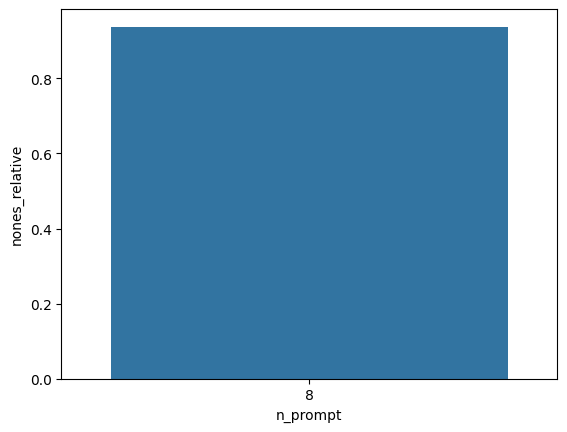

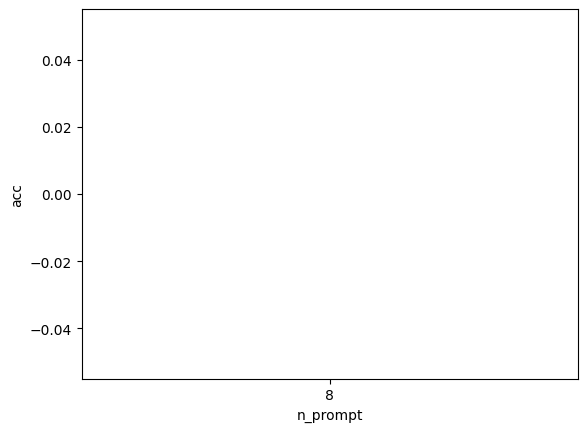

<Figure size 640x480 with 0 Axes>

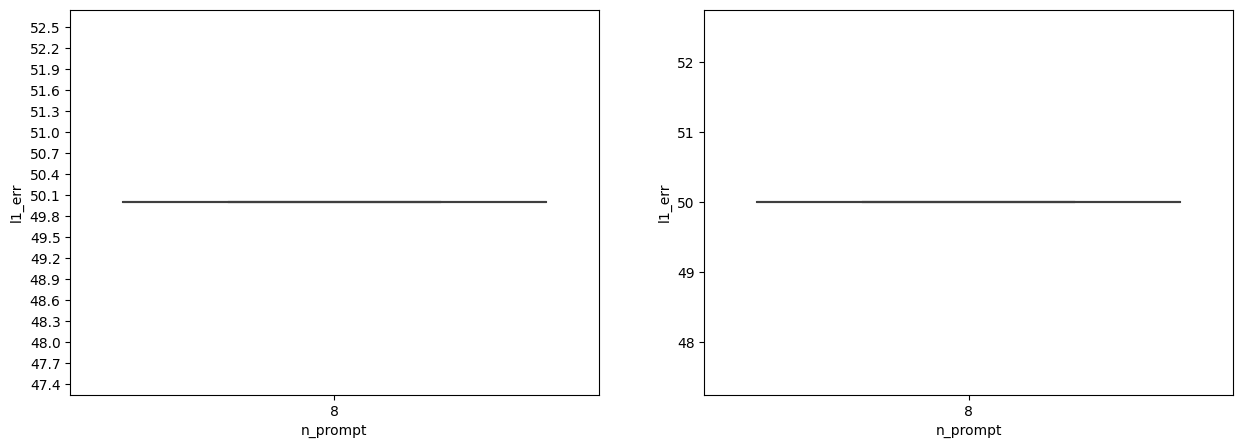

<Figure size 640x480 with 0 Axes>

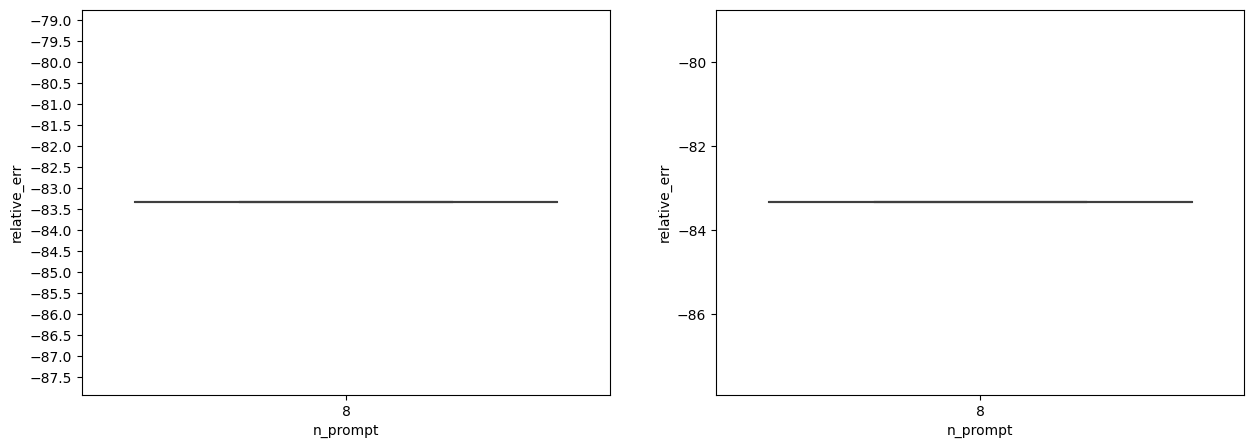

In [210]:
plot_metrics(get_metrics(bloom_7b_self_consistency_new_prompt_with_nones))

n_prompt = 8 mean l1_err = 1333.4375
n_prompt = 8 mean relative_err = 98.84506826998992


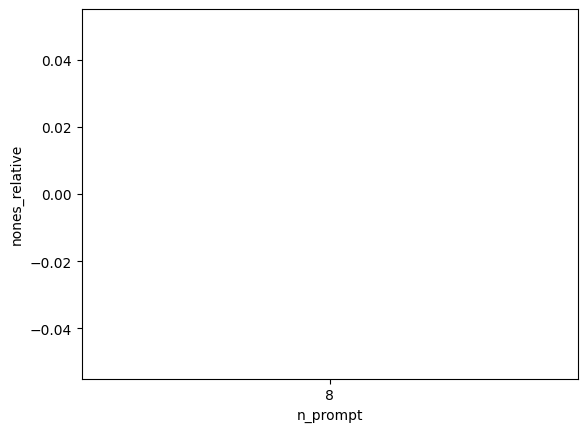

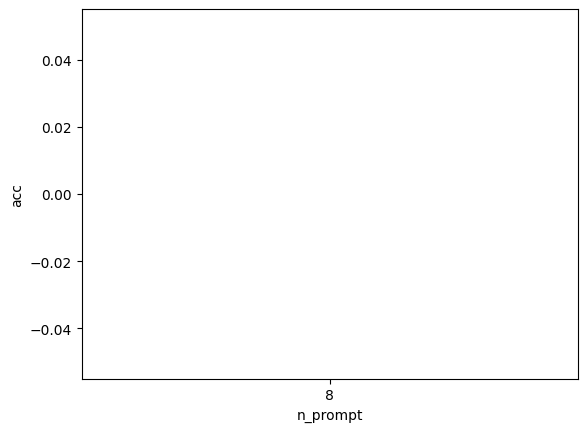

<Figure size 640x480 with 0 Axes>

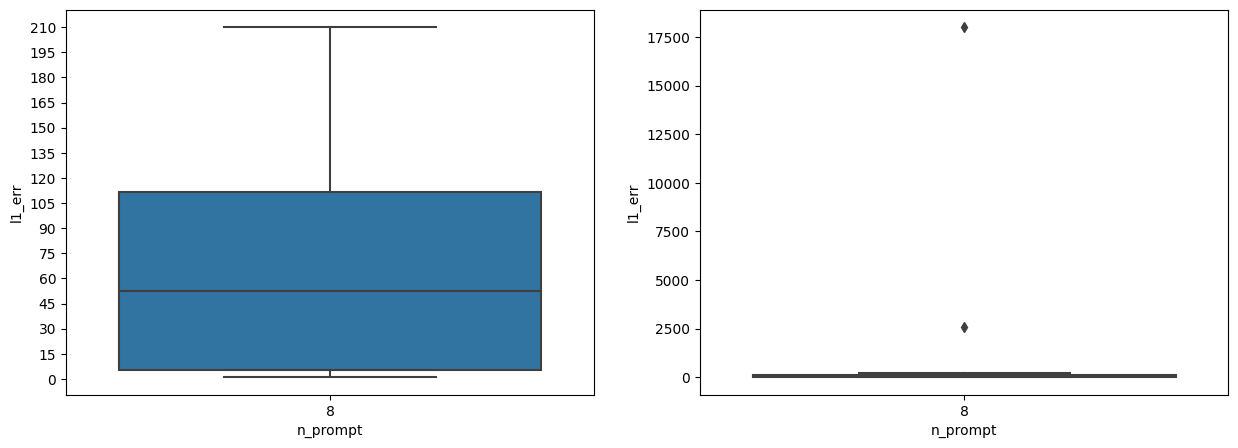

<Figure size 640x480 with 0 Axes>

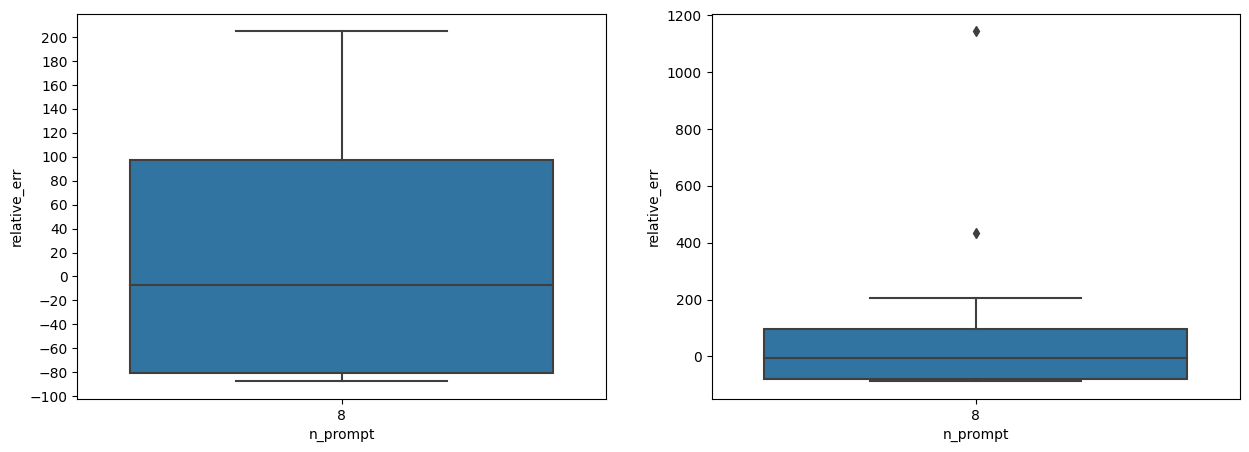

In [211]:
plot_metrics(get_metrics(bloom_7b_self_consistency_new_prompt_without_nones))